# **Stock Momentum Pipeline**


 **Ethical Considerations**
  - This project uses public stock market data and news from CNN only.No ethical considerations need to be done.

## **Flow Chart**

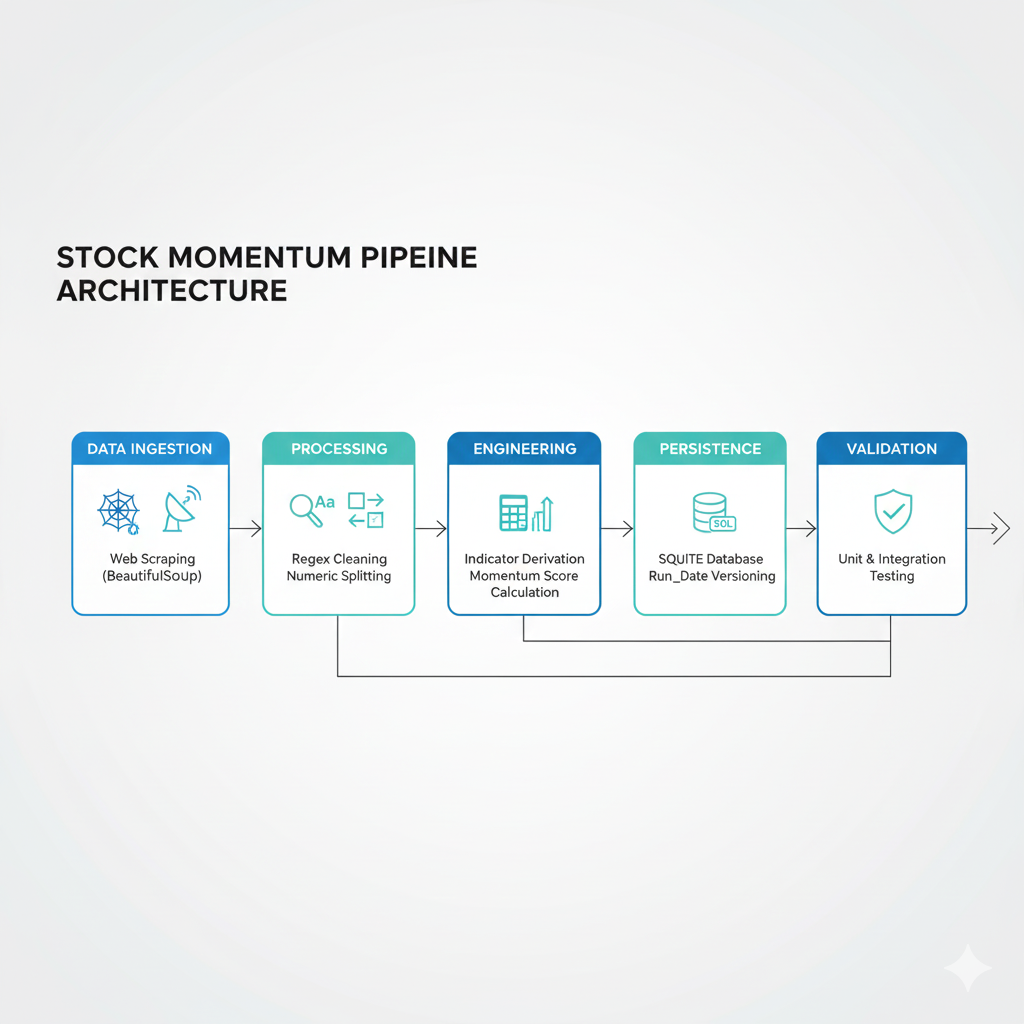**

-  It starts with Data Ingestion (web scraping via BeautifulSoup), then Processing (regex cleaning and numeric splitting), followed by Engineering (indicator derivation and momentum score calculation), then Persistence (SQLite database with run-date versioning), finally Validation (unit and integration testing).

## 1. **Data Acquisition**

* **Method:** BeautifulSoup + requests (6 page web scraping) + yfinance API (OHLCV data)  
* **Ethical Note:** User-Agent headers included; strictly public market data only.  
* **Output:** Unique symbols with financial data (varies by market conditions/day)






In [ ]:
import requests
import pandas as pd

### Collecting data using web scraping from yahoo finance and obtaining the ohlcv data using yfinance

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
urls = [
    "https://finance.yahoo.com/markets/stocks/most-active/",
    "https://finance.yahoo.com/markets/stocks/gainers/",
    "https://finance.yahoo.com/markets/stocks/losers/",
    "https://finance.yahoo.com/markets/stocks/52-week-gainers/",
    "https://finance.yahoo.com/markets/stocks/52-week-losers/",
    "https://finance.yahoo.com/markets/stocks/large-cap-stocks/"
]

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

In [ ]:
def scrape(urls):
  all_symbol_data = []
  all_symbols = []
  for url in urls:
      response = requests.get(url, headers=headers)
      if response.status_code == 200:
          soup = BeautifulSoup(response.text, 'html.parser')
          tables = soup.find_all('table')
          if tables:
              for table in tables:
                  rows = []
                  for tr in table.find_all('tr'):
                      cells = [cell.get_text(strip=True) for cell in tr.find_all(['td', 'th'])]
                      if cells:
                          rows.append(cells)
                  df = pd.DataFrame(rows)
                  if len(df) > 1:
                      df.columns = df.iloc[0]
                      df = df[1:]
                      all_symbol_data.append(df)
                      symbols = df['Symbol'].tolist()
                      all_symbols.extend(symbols)
                  return all_symbol_data, all_symbols
          else:
              print(f"No tables found on the page: {url}")
      else:
          print(f"Failed to retrieve page {url} with status code {response.status_code}")


In [ ]:
all_symbol_data, all_symbols = scrape(urls)

In [ ]:
combined_symbol_df = pd.concat(all_symbol_data, ignore_index=True).drop_duplicates(subset=['Symbol'])
unique_symbols = list(set(all_symbols))
cols_to_drop = ['Avg vol (3m)', 'Market cap', '52 Wk range']
combined_symbol_df = combined_symbol_df.drop(columns=[col for col in cols_to_drop if col in combined_symbol_df.columns])
combined_symbol_df

,Symbol,Name,,Price,Change,Change %,Volume,Avg Vol (3M),Market Cap,P/E Ratio(TTM),52 WkChange %,52 Wk Range
0,NVDA,NVIDIA Corporation,,175.02-5.91(-3.27%),-5.91,-3.27%,175.403M,191.063M,4.261T,43.32,+37.07%,86.62212.19
1,BBAI,"BigBear.ai Holdings, Inc.",,6.38-0.36(-5.34%),-0.36,-5.34%,159.631M,124.776M,2.785B,--,+125.42%,2.3610.36
2,PLUG,Plug Power Inc.,,2.32-0.04(-1.69%),-0.04,-1.69%,111.634M,137.183M,3.228B,--,-3.67%,0.694.58
3,RIVN,"Rivian Automotive, Inc.",,18.42+1.99(+12.11%),+1.99,+12.11%,98.994M,47.964M,22.581B,--,+7.11%,10.3618.60
4,TSLA,"Tesla, Inc.",,458.96+12.09(+2.71%),+12.09,+2.71%,90.515M,86.312M,1.526T,316.72,-3.48%,214.25488.54
5,ONDS,Ondas Holdings Inc.,,8.75-0.27(-2.99%),-0.27,-2.99%,87.311M,79.272M,3.26B,--,+443.37%,0.5711.70
6,AVGO,Broadcom Inc.,,359.93-46.44(-11.43%),-46.44,-11.43%,83.923M,23.094M,1.7T,75.46,+62.55%,138.10414.61
7,INTC,Intel Corporation,,37.81-1.70(-4.30%),-1.70,-4.30%,67.025M,116.222M,180.354B,839.79,+89.68%,17.6744.02
8,FRMI,Fermi Inc.,,10.09-5.16(-33.84%),-5.16,-33.84%,62.579M,5.787M,6.196B,--,-53.12%,12.8836.99
9,ORCL,Oracle Corporation,,189.97-8.88(-4.47%),-8.88,-4.47%,52.383M,25.944M,545.809B,35.66,+16.13%,118.86345.72


In [ ]:
import yfinance as yf

In [ ]:
def get_ohlcv(unique_symbols):
  ohlcv_symb = []
  for symbol in unique_symbols:
      ticker = yf.Ticker(symbol)
      hist = ticker.history(period="2d")
      hist = hist[['Open', 'High', 'Low', 'Close', 'Volume']]
      hist['Symbol'] = symbol
      hist['Prev_close'] = hist['Close'].shift(1)
      hist = hist.reset_index()
      last_row = hist.tail(1)
      ohlcv_symb.append(last_row)
  return ohlcv_symb

In [ ]:
ohlcv_symb = get_ohlcv(unique_symbols)
ohlcv_df = pd.concat(ohlcv_symb, ignore_index=True)
final_df = pd.merge(combined_symbol_df, ohlcv_df, on='Symbol', how='inner')

In [ ]:
final_df.drop(columns=['Volume_x'], inplace=True, errors='ignore')
final_df.rename(columns={'Volume_y': 'Volume'}, inplace=True)
final_df.drop(columns='', inplace=True, errors='ignore')
final_df.sort_values(by='Symbol', inplace=True)
print(final_df.head(10).to_string(index=False))

Symbol                                 Name                 Price Change Change % Avg Vol (3M) Market Cap P/E Ratio(TTM) 52 WkChange %  52 Wk Range                      Date       Open       High        Low      Close    Volume  Prev_close
   AAL         American Airlines Group Inc.      14.960.00(0.00%)   0.00    0.00%      65.186M     9.875B          13.45        -9.44%    8.5019.10 2025-12-12 00:00:00-05:00  15.180000  15.336500  14.940000  14.960000  38205243   14.960000
  ACHR                 Archer Aviation Inc.     8.30-0.26(-3.04%)  -0.26   -3.04%      60.493M     6.093B             --        -3.49%    5.4814.62 2025-12-12 00:00:00-05:00   8.610000   8.820000   8.220000   8.300000  38789887    8.560000
  AVGO                        Broadcom Inc. 359.93-46.44(-11.43%) -46.44  -11.43%      23.094M       1.7T          75.46       +62.55% 138.10414.61 2025-12-12 00:00:00-05:00 379.959991 380.920013 355.149994 359.929993  91367205  406.369995
  BBAI            BigBear.ai Holdings, I

### My approach is to first scrape data on the most active stocks directly from the web. Then i use those stock symbols to pull their historical market data through the yfinance library. From this historical data, I calculate various financial Indicators to support my analysis

## 2. **Data Preprocessing**

* **Method:** Custom functions for data cleaning.
* **Process:**
  - Removed invalid symbols and null values while preserving maximum viable data
  - Dropped irrelevant columns (Avg Vol 3M, Market Cap, 52 Wk Range)  
* **Output:** Clean dataset  ready for analysis








In [ ]:
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 15 to 17
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype                           
---  ------          --------------  -----                           
 0   Symbol          25 non-null     object                          
 1   Name            25 non-null     object                          
 2   Price           25 non-null     object                          
 3   Change          25 non-null     object                          
 4   Change %        25 non-null     object                          
 5   Avg Vol (3M)    25 non-null     object                          
 6   Market Cap      25 non-null     object                          
 7   P/E Ratio(TTM)  25 non-null     object                          
 8   52 WkChange %   25 non-null     object                          
 9   52 Wk Range     25 non-null     object                          
 10  Date            25 non-null     datetime64[ns, America/N



*   **Dropping the price column as close and price are of same values**




In [ ]:
final_df.drop(columns=['Price'],inplace=True)
final_df.drop(columns=['P/E Ratio(TTM)'],inplace=True)

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 15 to 17
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype                           
---  ------         --------------  -----                           
 0   Symbol         25 non-null     object                          
 1   Name           25 non-null     object                          
 2   Change         25 non-null     object                          
 3   Change %       25 non-null     object                          
 4   Avg Vol (3M)   25 non-null     object                          
 5   Market Cap     25 non-null     object                          
 6   52 WkChange %  25 non-null     object                          
 7   52 Wk Range    25 non-null     object                          
 8   Date           25 non-null     datetime64[ns, America/New_York]
 9   Open           25 non-null     float64                         
 10  High           25 non-null     float64                         
 11 



*   **Type Casting**




In [ ]:
import re
import numpy as np

def clean_numeric(val):
    if pd.isnull(val):
        return np.nan
    s = str(val).strip().replace(',', '').replace('+', '').replace('%', '').replace('-','')
    if s == '--':
        return np.nan
    if s.endswith('M'):
        return float(s[:-1]) * 1e6
    elif s.endswith('B'):
        return float(s[:-1]) * 1e9
    elif s.endswith('T'):
        return float(s[:-1]) * 1e12
    try:
        return float(s)
    except:
        return np.nan
str_cols = ['Avg Vol (3M)', 'Market Cap', '52 WkChange %','Change','Change %']
for col in str_cols:
    final_df[col] = final_df[col].apply(clean_numeric)

print(final_df[['Symbol','Change','Change %', 'Market Cap', 'Avg Vol (3M)','52 WkChange %']].head(10))



   Symbol  Change  Change %    Market Cap  Avg Vol (3M)  52 WkChange %
15    AAL    0.00      0.00  9.875000e+09    65186000.0           9.44
24   ACHR    0.26      3.04  6.093000e+09    60493000.0           3.49
6    AVGO   46.44     11.43  1.700000e+12    23094000.0          62.55
1    BBAI    0.36      5.34  2.785000e+09   124776000.0         125.42
16   BMNR    3.52      9.17  1.484500e+10    46715000.0         395.23
23   CLSK    0.79      5.33  3.751000e+09    36199000.0          18.75
12    DNN    0.15      5.43  2.342000e+09    83141000.0          34.63
13      F    0.13      0.95  5.482700e+10    92679000.0          36.44
8    FRMI    5.16     33.84  6.196000e+09     5787000.0          53.12
7    INTC    1.70      4.30  1.803540e+11   116222000.0          89.68


In [ ]:

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 15 to 17
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype                           
---  ------         --------------  -----                           
 0   Symbol         25 non-null     object                          
 1   Name           25 non-null     object                          
 2   Change         25 non-null     float64                         
 3   Change %       25 non-null     float64                         
 4   Avg Vol (3M)   25 non-null     float64                         
 5   Market Cap     25 non-null     float64                         
 6   52 WkChange %  25 non-null     float64                         
 7   52 Wk Range    25 non-null     object                          
 8   Date           25 non-null     datetime64[ns, America/New_York]
 9   Open           25 non-null     float64                         
 10  High           25 non-null     float64                         
 11 



*   **Separating the 52 Week Range to 52 Week high and low**




In [ ]:
def splitlow_high(range_str):
    s = str(range_str).replace(',', '').strip()
    match = re.match(r'(\d+\.\d{2})(.*)', s)
    if match:
        low_str = match.group(1)
        high_str = match.group(2)
        return float(low_str), float(high_str)

    return None, None

In [ ]:
final_df[['52_week_low', '52_week_high']] = final_df['52 Wk Range'].apply(
    lambda x: pd.Series(splitlow_high(x))
)

In [ ]:
final_df[['52 Wk Range', '52_week_low', '52_week_high']].head(10)

,52 Wk Range,52_week_low,52_week_high
15,8.5019.10,8.50,19.10
24,5.4814.62,5.48,14.62
6,138.10414.61,138.10,414.61
1,2.3610.36,2.36,10.36
16,3.92161.00,3.92,161.00
23,6.4523.61,6.45,23.61
12,1.083.42,1.08,3.42
13,8.4413.97,8.44,13.97
8,12.8836.99,12.88,36.99
7,17.6744.02,17.67,44.02


In [ ]:
final_df.drop(columns=['52 Wk Range'],inplace=True)

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 15 to 17
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype                           
---  ------         --------------  -----                           
 0   Symbol         25 non-null     object                          
 1   Name           25 non-null     object                          
 2   Change         25 non-null     float64                         
 3   Change %       25 non-null     float64                         
 4   Avg Vol (3M)   25 non-null     float64                         
 5   Market Cap     25 non-null     float64                         
 6   52 WkChange %  25 non-null     float64                         
 7   Date           25 non-null     datetime64[ns, America/New_York]
 8   Open           25 non-null     float64                         
 9   High           25 non-null     float64                         
 10  Low            25 non-null     float64                         
 11 



*   **Dropping the null values**



In [ ]:
final_df.dropna(inplace=True)

In [ ]:
final_df_clean=final_df.copy()

In [ ]:
final_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 15 to 17
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype                           
---  ------         --------------  -----                           
 0   Symbol         24 non-null     object                          
 1   Name           24 non-null     object                          
 2   Change         24 non-null     float64                         
 3   Change %       24 non-null     float64                         
 4   Avg Vol (3M)   24 non-null     float64                         
 5   Market Cap     24 non-null     float64                         
 6   52 WkChange %  24 non-null     float64                         
 7   Date           24 non-null     datetime64[ns, America/New_York]
 8   Open           24 non-null     float64                         
 9   High           24 non-null     float64                         
 10  Low            24 non-null     float64                         
 11 

In [ ]:
final_df_clean.head(10)

,Symbol,Name,Change,Change %,Avg Vol (3M),Market Cap,52 WkChange %,Date,Open,High,Low,Close,Volume,Prev_close,52_week_low,52_week_high
15,AAL,American Airlines Group Inc.,0.00,0.00,65186000.0,9.875000e+09,9.44,2025-12-12 00:00:00-05:00,15.180000,15.336500,14.940000,14.960000,38205243,14.960000,8.50,19.10
24,ACHR,Archer Aviation Inc.,0.26,3.04,60493000.0,6.093000e+09,3.49,2025-12-12 00:00:00-05:00,8.610000,8.820000,8.220000,8.300000,38789887,8.560000,5.48,14.62
6,AVGO,Broadcom Inc.,46.44,11.43,23094000.0,1.700000e+12,62.55,2025-12-12 00:00:00-05:00,379.959991,380.920013,355.149994,359.929993,91367205,406.369995,138.10,414.61
1,BBAI,"BigBear.ai Holdings, Inc.",0.36,5.34,124776000.0,2.785000e+09,125.42,2025-12-12 00:00:00-05:00,6.670000,6.965000,6.170000,6.380000,160214593,6.740000,2.36,10.36
16,BMNR,"Bitmine Immersion Technologies, Inc.",3.52,9.17,46715000.0,1.484500e+10,395.23,2025-12-12 00:00:00-05:00,38.500000,38.759998,34.750000,34.860001,50908603,38.380001,3.92,161.00
23,CLSK,"CleanSpark, Inc.",0.79,5.33,36199000.0,3.751000e+09,18.75,2025-12-12 00:00:00-05:00,14.670000,15.485000,13.990000,14.030000,37385929,14.820000,6.45,23.61
12,DNN,Denison Mines Corp.,0.15,5.43,83141000.0,2.342000e+09,34.63,2025-12-12 00:00:00-05:00,2.790000,2.790000,2.540000,2.610000,49018852,2.760000,1.08,3.42
13,F,Ford Motor Company,0.13,0.95,92679000.0,5.482700e+10,36.44,2025-12-12 00:00:00-05:00,13.670000,13.840000,13.670000,13.760000,47856716,13.630000,8.44,13.97
8,FRMI,Fermi Inc.,5.16,33.84,5787000.0,6.196000e+09,53.12,2025-12-12 00:00:00-05:00,9.180000,10.880000,8.300000,10.090000,63073982,15.250000,12.88,36.99
7,INTC,Intel Corporation,1.70,4.30,116222000.0,1.803540e+11,89.68,2025-12-12 00:00:00-05:00,39.244999,40.029999,37.619999,37.810001,83727113,39.509998,17.67,44.02


## 3. **Technical Indicators**



*   **Purpose:** Extract 7 actionable trading signals for swing trading analysis  
*   **Method:** Created `indicators` table and `swing trade` table with core fields: `Date`, `Symbol`, `Name`, `Close`, plus derived price action (DailyReturn, BodySize, Gap), volume ratio, and volatility metrics (TrueRange, IntradayRange). These features were then used to calculate Momentum Score for swing trading signals.



In [ ]:
Indicators=pd.DataFrame()
Indicators["Date"]=final_df_clean['Date']
Indicators["Symbol"]=final_df_clean['Symbol']
Indicators["Names"]=final_df_clean['Name']
Indicators["LTP"]=final_df_clean['Close']

### Price Action and Momentum Indicators
* Daily Return: (Close - Prev_close)/Prev_close ​
* Intraday Range: (High - Low)/Prev_close
* Body Size: (Close - Open)/Prev_close
* Upper/Lower Shadow: (High - max(Open,Close))/Prev_close, (min(Open,Close) - Low)/Prev_close

In [ ]:
Indicators["Daily_return"]=(final_df_clean['Close']-final_df_clean['Prev_close'])/final_df_clean['Prev_close']
Indicators["Intraday_range"]=(final_df_clean['High']-final_df_clean['Low'])/final_df_clean['Prev_close']
Indicators["Body_size"]=(final_df_clean['Close']-final_df_clean['Open'])/final_df_clean['Prev_close']
Indicators["Upper_shadow"] = (final_df_clean['High'] - final_df_clean[['Open', 'Close']].max(axis=1)) / final_df_clean['Prev_close']
Indicators["Lower_shadow"] = (final_df_clean[['Open', 'Close']].min(axis=1) - final_df_clean['Low']) / final_df_clean['Prev_close']

In [ ]:
Indicators.head(10)


,Date,Symbol,Names,LTP,Daily_return,Intraday_range,Body_size,Upper_shadow,Lower_shadow
15,2025-12-12 00:00:00-05:00,AAL,American Airlines Group Inc.,14.960000,0.000000,0.026504,-0.014706,0.010461,0.001337
24,2025-12-12 00:00:00-05:00,ACHR,Archer Aviation Inc.,8.300000,-0.030374,0.070093,-0.036215,0.024533,0.009346
6,2025-12-12 00:00:00-05:00,AVGO,Broadcom Inc.,359.929993,-0.114280,0.063415,-0.049290,0.002362,0.011763
1,2025-12-12 00:00:00-05:00,BBAI,"BigBear.ai Holdings, Inc.",6.380000,-0.053412,0.117953,-0.043027,0.043769,0.031157
16,2025-12-12 00:00:00-05:00,BMNR,"Bitmine Immersion Technologies, Inc.",34.860001,-0.091714,0.104481,-0.094841,0.006774,0.002866
23,2025-12-12 00:00:00-05:00,CLSK,"CleanSpark, Inc.",14.030000,-0.053306,0.100877,-0.043185,0.054993,0.002699
12,2025-12-12 00:00:00-05:00,DNN,Denison Mines Corp.,2.610000,-0.054348,0.090580,-0.065217,0.000000,0.025362
13,2025-12-12 00:00:00-05:00,F,Ford Motor Company,13.760000,0.009538,0.012472,0.006603,0.005869,0.000000
8,2025-12-12 00:00:00-05:00,FRMI,Fermi Inc.,10.090000,-0.338361,0.169180,0.059672,0.051803,0.057705
7,2025-12-12 00:00:00-05:00,INTC,Intel Corporation,37.810001,-0.043027,0.060997,-0.036320,0.019868,0.004809


### **Volume Metrics**

*   Volume Ratio: Volume / Avg Vol
*   Price-Volume Trend: Volume > Avg and Close > Open flags accumulation​

In [ ]:
Indicators['Volume_ratio']=final_df_clean['Volume']/final_df_clean['Avg Vol (3M)']
Indicators['Price_Volume_Trend'] = ((final_df_clean['Volume'] > final_df_clean['Avg Vol (3M)']) & (final_df_clean['Close'] > final_df_clean['Open'])).astype(int)

In [ ]:
Indicators.head(10)

,Date,Symbol,Names,LTP,Daily_return,Intraday_range,Body_size,Upper_shadow,Lower_shadow,Volume_ratio,Price_Volume_Trend
15,2025-12-12 00:00:00-05:00,AAL,American Airlines Group Inc.,14.960000,0.000000,0.026504,-0.014706,0.010461,0.001337,0.586096,0
24,2025-12-12 00:00:00-05:00,ACHR,Archer Aviation Inc.,8.300000,-0.030374,0.070093,-0.036215,0.024533,0.009346,0.641229,0
6,2025-12-12 00:00:00-05:00,AVGO,Broadcom Inc.,359.929993,-0.114280,0.063415,-0.049290,0.002362,0.011763,3.956318,0
1,2025-12-12 00:00:00-05:00,BBAI,"BigBear.ai Holdings, Inc.",6.380000,-0.053412,0.117953,-0.043027,0.043769,0.031157,1.284018,0
16,2025-12-12 00:00:00-05:00,BMNR,"Bitmine Immersion Technologies, Inc.",34.860001,-0.091714,0.104481,-0.094841,0.006774,0.002866,1.089770,0
23,2025-12-12 00:00:00-05:00,CLSK,"CleanSpark, Inc.",14.030000,-0.053306,0.100877,-0.043185,0.054993,0.002699,1.032789,0
12,2025-12-12 00:00:00-05:00,DNN,Denison Mines Corp.,2.610000,-0.054348,0.090580,-0.065217,0.000000,0.025362,0.589587,0
13,2025-12-12 00:00:00-05:00,F,Ford Motor Company,13.760000,0.009538,0.012472,0.006603,0.005869,0.000000,0.516371,0
8,2025-12-12 00:00:00-05:00,FRMI,Fermi Inc.,10.090000,-0.338361,0.169180,0.059672,0.051803,0.057705,10.899254,1
7,2025-12-12 00:00:00-05:00,INTC,Intel Corporation,37.810001,-0.043027,0.060997,-0.036320,0.019868,0.004809,0.720407,0


### **Volatility Proxies**

*   True Range Approx: max(High-Low, abs(High-Prev_close), abs(Low-Prev_close))
*   Gap: (Open - Prev_close)/Prev_close


In [ ]:
Indicators['Gap'] = (final_df_clean['Open'] - final_df_clean['Prev_close']) / final_df_clean['Prev_close']
Indicators['True_Range_Approx'] = np.maximum.reduce([final_df_clean['High'] - final_df_clean['Low'],np.abs(final_df_clean['High'] - final_df_clean['Prev_close']),np.abs(final_df_clean['Low'] - final_df_clean['Prev_close'])]) / final_df_clean['Prev_close']

In [ ]:
# @title
Indicators.head(10)

,Date,Symbol,Names,LTP,Daily_return,Intraday_range,Body_size,Upper_shadow,Lower_shadow,Volume_ratio,Price_Volume_Trend,Gap,True_Range_Approx
15,2025-12-12 00:00:00-05:00,AAL,American Airlines Group Inc.,14.960000,0.000000,0.026504,-0.014706,0.010461,0.001337,0.586096,0,0.014706,0.026504
24,2025-12-12 00:00:00-05:00,ACHR,Archer Aviation Inc.,8.300000,-0.030374,0.070093,-0.036215,0.024533,0.009346,0.641229,0,0.005841,0.070093
6,2025-12-12 00:00:00-05:00,AVGO,Broadcom Inc.,359.929993,-0.114280,0.063415,-0.049290,0.002362,0.011763,3.956318,0,-0.064990,0.126043
1,2025-12-12 00:00:00-05:00,BBAI,"BigBear.ai Holdings, Inc.",6.380000,-0.053412,0.117953,-0.043027,0.043769,0.031157,1.284018,0,-0.010386,0.117953
16,2025-12-12 00:00:00-05:00,BMNR,"Bitmine Immersion Technologies, Inc.",34.860001,-0.091714,0.104481,-0.094841,0.006774,0.002866,1.089770,0,0.003127,0.104481
23,2025-12-12 00:00:00-05:00,CLSK,"CleanSpark, Inc.",14.030000,-0.053306,0.100877,-0.043185,0.054993,0.002699,1.032789,0,-0.010121,0.100877
12,2025-12-12 00:00:00-05:00,DNN,Denison Mines Corp.,2.610000,-0.054348,0.090580,-0.065217,0.000000,0.025362,0.589587,0,0.010870,0.090580
13,2025-12-12 00:00:00-05:00,F,Ford Motor Company,13.760000,0.009538,0.012472,0.006603,0.005869,0.000000,0.516371,0,0.002935,0.015407
8,2025-12-12 00:00:00-05:00,FRMI,Fermi Inc.,10.090000,-0.338361,0.169180,0.059672,0.051803,0.057705,10.899254,1,-0.398033,0.455738
7,2025-12-12 00:00:00-05:00,INTC,Intel Corporation,37.810001,-0.043027,0.060997,-0.036320,0.019868,0.004809,0.720407,0,-0.006707,0.060997


### **Momentum Score**

The Momentum Score excels as a swing trading screener by combining price strength (>5% daily return), volume surge (>1.2x average), accumulation (high volume + green candle), and volatility (>5% true range), scoring stocks 0-5 to identify high-conviction setups ≥3.

In [ ]:
Indicators['Momentum_Score'] = (
    (Indicators['Daily_return'] > 0.05).astype(int) * 2 +
    (Indicators['Volume_ratio'] > 1.2).astype(int) +
    Indicators['Price_Volume_Trend'] +
    (Indicators['True_Range_Approx'] > 0.05).astype(int)
)


In [ ]:
Indicators.sort_values(by='Symbol',inplace=True)

In [ ]:
print(Indicators[Indicators['Momentum_Score']>=4].to_string(index=False))

                     Date Symbol                   Names   LTP  Daily_return  Intraday_range  Body_size  Upper_shadow  Lower_shadow  Volume_ratio  Price_Volume_Trend      Gap  True_Range_Approx  Momentum_Score
2025-12-12 00:00:00-05:00   RIVN Rivian Automotive, Inc. 18.42       0.12112        0.174681   0.097383       0.07182      0.005478      2.151407                   1 0.023737            0.19294               5


In [ ]:
temp_highmomentum=pd.DataFrame()
temp_highmomentum['Symbol']=Indicators[Indicators['Momentum_Score']>=4]['Symbol']
temp_highmomentum['Date']=Indicators[Indicators['Momentum_Score']>=4]['Date']
temp_highmomentum['Momentum_Score']=Indicators[Indicators['Momentum_Score']>=4]['Momentum_Score']

,Symbol,Date,Momentum_Score
3,RIVN,2025-12-12 00:00:00-05:00,5


In [ ]:
Indicators.columns

Index(['Date', 'Symbol', 'Names', 'LTP', 'Daily_return', 'Intraday_range',
       'Body_size', 'Upper_shadow', 'Lower_shadow', 'Volume_ratio',
       'Price_Volume_Trend', 'Gap', 'True_Range_Approx', 'Momentum_Score'],
      dtype='object')

### Swing trade



In [ ]:
sf=temp_highmomentum.copy()
def advance_analysis(sf):
  for symbol in sf['Symbol'].unique():
    ticker=yf.Ticker(symbol)
    hist=ticker.history(period="3mo")
    close=hist['Close']
    sf.loc[sf['Symbol']==symbol,'LTP']=close.iloc[-1]
    ema20 = close.ewm(span=20).mean().iloc[-1]
    ema50= close.ewm(span=50).mean().iloc[-1]
    sma20 = close.rolling(20).mean().iloc[-1]
    sma50 = close.rolling(50).mean().iloc[-1]
    sf.loc[sf['Symbol']==symbol, 'EMA20'] = ema20
    sf.loc[sf['Symbol']==symbol, 'EMA50'] = ema50
    sf.loc[sf['Symbol']==symbol, 'SMA20'] = sma20
    sf.loc[sf['Symbol']==symbol, 'SMA50'] = sma50

    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    sf.loc[sf['Symbol']==symbol, 'RSI'] = 100 - (100 / (1 + rs)).iloc[-1]

    ema12 = close.ewm(span=12).mean()
    ema26 = close.ewm(span=26).mean()
    macd_line = ema12 - ema26
    macd = macd_line.iloc[-1]
    macd_signal = macd_line.ewm(span=9).mean().iloc[-1]
    sf.loc[sf['Symbol']==symbol, 'MACD'] = macd
    sf.loc[sf['Symbol']==symbol, 'MACD_Signal'] = macd_signal

    bb_middle = close.rolling(20).mean().iloc[-1]
    bb_std = close.rolling(20).std().iloc[-1]
    sf.loc[sf['Symbol']==symbol, 'BB_Upper'] = bb_middle + (bb_std * 2)
    sf.loc[sf['Symbol']==symbol, 'BB_Middle'] = bb_middle
    sf.loc[sf['Symbol']==symbol, 'BB_Lower'] = bb_middle - (bb_std * 2)

    sf.loc[sf['Symbol']==symbol, 'Golden_Cross'] = int((sma20 > sma50) & (sma20 <= close.iloc[-1]))
    sf.loc[sf['Symbol']==symbol, 'Death_Cross'] = int((sma20 < sma50) & (sma20 >= close.iloc[-1]))

In [ ]:
advance_analysis(sf)
sf.head(10)

,Symbol,Date,Momentum_Score,LTP,EMA20,EMA50,SMA20,SMA50,RSI,MACD,MACD_Signal,BB_Upper,BB_Middle,BB_Lower,Golden_Cross,Death_Cross
3,RIVN,2025-12-12 00:00:00-05:00,5,18.42,16.726757,15.750003,16.429,14.9178,75.356144,0.775426,0.740782,19.058764,16.429,13.799236,1.0,0.0


### News Analysis

In [ ]:
import nltk
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
for symbol in sf['Symbol'].unique():
  resp=requests.get(f"https://edition.cnn.com/markets/stocks/{symbol}")
  soup = BeautifulSoup(resp.text, 'html.parser')
  news_div = soup.find("div", class_="markets-company-news__items")
  data = []
  for a in news_div.find_all("a", class_="markets-company-news__item", href=True):
    headline = a.find("span", class_="markets-company-news__item--title").get_text(strip=True)
    data.append({ "headline": headline})
    c=+1
  compounds = []
  for item in data:
      scores = sia.polarity_scores(item["headline"])
      item["compound"] = scores["compound"]
      compounds.append(scores["compound"])
  overall_compound = np.average(compounds)
  if overall_compound >= 0.05:
    sf.loc[sf['Symbol']==symbol, 'News_Analysis'] = 1
  elif overall_compound <= -0.05:
      sf.loc[sf['Symbol']==symbol, 'News_Analysis'] = -1
  else:
      sf.loc[sf['Symbol']==symbol, 'News_Analysis'] = 0

sf.head(10)

,Symbol,Date,Momentum_Score,LTP,EMA20,EMA50,SMA20,SMA50,RSI,MACD,MACD_Signal,BB_Upper,BB_Middle,BB_Lower,Golden_Cross,Death_Cross,News_Analysis
3,RIVN,2025-12-12 00:00:00-05:00,5,18.42,16.726757,15.750003,16.429,14.9178,75.356144,0.775426,0.740782,19.058764,16.429,13.799236,1.0,0.0,0.0


## 4. **Database**

* **Purpose:** Storage for ETL pipeline with deduplication and schema validation.The db is stored in google drive which could be used for any CRUD operations.
* **Method:** SQLite3 with 3 table schema {Final_clean,Indiactors,Swing_Trade}




### **Database Creation**




In [ ]:
import sqlite3
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
db_path = 'your.path'
conn = sqlite3.connect(db_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
final_df_clean_today = final_df_clean.copy()
final_df_clean_today['Run_Date'] = now
Indicators_today = Indicators.copy()
Indicators_today['Run_Date'] = now
sf_today = sf.copy()
sf_today['Run_Date'] = now

In [ ]:
Indicators_today.head()

,Date,Symbol,Names,LTP,Daily_return,Intraday_range,Body_size,Upper_shadow,Lower_shadow,Volume_ratio,Price_Volume_Trend,Gap,True_Range_Approx,Momentum_Score,Run_Date
15,2025-12-12 00:00:00-05:00,AAL,American Airlines Group Inc.,14.960000,0.000000,0.026504,-0.014706,0.010461,0.001337,0.713987,0,0.014706,0.026504,0,2025-12-13 16:12:30
62,2025-12-12 00:00:00-05:00,AAOI,"Applied Optoelectronics, Inc.",32.060001,-0.117291,0.097739,-0.094163,0.000273,0.003304,1.004229,0,-0.023128,0.120595,1,2025-12-13 16:12:30
112,2025-12-12 00:00:00-05:00,AAPL,Apple Inc.,278.279999,0.000899,0.008632,0.001744,0.003381,0.003507,0.781010,0,-0.000845,0.008632,0,2025-12-13 16:12:30
130,2025-12-12 00:00:00-05:00,ABBV,AbbVie Inc.,223.320007,-0.002947,0.012144,-0.001630,0.000603,0.009912,0.904530,0,-0.001317,0.012858,0,2025-12-13 16:12:30
75,2025-12-12 00:00:00-05:00,ABVX,ABIVAX Société Anonyme,125.544998,-0.056691,0.061688,-0.027951,0.013187,0.020550,1.260029,0,-0.028740,0.077241,2,2025-12-13 16:12:30


In [ ]:
database_data = {
        'final_clean': final_df_clean_today,
        'indicators': Indicators_today,
        'swing_trade': sf_today
    }

In [ ]:
for tablename, df in database_data.items():
    cursor = conn.cursor()
    cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{tablename}'")
    table_exists = cursor.fetchone()

    if not table_exists:
        df.to_sql(tablename, conn, if_exists='replace', index=False)
    else:
        print("APPEND TO EXISTING", tablename)
        df.to_sql(tablename, conn, if_exists='append', index=False, method='multi')
        totalrows = pd.read_sql(f"SELECT COUNT(*) as count FROM {tablename}", conn)
        count = totalrows.iloc[0]["count"]
        print(tablename, "total rows", count)

APPEND TO EXISTING final_clean
final_clean total rows 1377
APPEND TO EXISTING indicators
indicators total rows 1377


In [ ]:
conn.close()




### **Database Validation**




In [ ]:
from google.colab import drive
drive.mount('/content/drive')
db_path = 'your.path'
conn = sqlite3.connect(db_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Database Tables:")
print(tables)

Database Tables:
          name
0   indicators
1  final_clean
2  swing_trade


In [ ]:
print("\nFinal_clean (Latest 10 rows):")
final_preview = pd.read_sql("SELECT * FROM final_clean LIMIT 10;", conn)
print(final_preview.to_string(index=False))


Final_clean (Latest 10 rows):
Symbol                         Name  Change  Change %  Avg Vol (3M)   Market Cap  52 WkChange %                      Date        Open        High         Low       Close   Volume  Prev_close  52_week_low  52_week_high            Run_Date
   AAL American Airlines Group Inc.    0.28      2.01    68838000.0 9.400000e+09           4.30 2025-12-02 00:00:00-05:00   14.060000   14.330000   13.820000   14.240000 64564600   13.960000         8.50         19.10 2025-12-03 13:26:56
  AAPL                   Apple Inc.    3.09      1.09    51269000.0 4.247000e+12          17.77 2025-12-02 00:00:00-05:00  283.000000  287.399994  282.630005  286.190002 53615500  283.100006       169.21        287.40 2025-12-03 13:26:56
  ABTC        American Bitcoin Corp    1.39     38.83     5700000.0 2.031000e+09          35.87 2025-12-02 00:00:00-05:00    2.740000    2.740000    1.740000    2.190000 87476300    3.580000         0.63         14.65 2025-12-03 13:26:56
  ABVX       ABIV

In [ ]:
print("\nSwing Trade (Latest 10 rows):")
final_preview = pd.read_sql("SELECT * FROM swing_trade LIMIT 10;", conn)
print(final_preview.to_string(index=False))


Swing Trade (Latest 10 rows):
Symbol                      Date  Momentum_Score        LTP      EMA20      EMA50      SMA20      SMA50       RSI      MACD  MACD_Signal   BB_Upper  BB_Middle   BB_Lower  Golden_Cross  Death_Cross  News_Analysis            Run_Date
   CAE 2025-12-12 00:00:00-05:00               5  29.840000  27.471967  27.396138  26.897000  27.462800 89.308141  0.384831     0.034971  29.047683  26.897000  24.746317           0.0          0.0            1.0 2025-12-13 16:12:30
   CCC 2025-12-12 00:00:00-05:00               5   7.680000   7.454453   7.840030   7.299500   8.140000 63.855432 -0.166343    -0.240820   7.620713   7.299500   6.978287           0.0          0.0            1.0 2025-12-13 16:12:30
  EVCM 2025-12-12 00:00:00-05:00               5  12.080000   9.810275   9.967851   9.159000  10.209400 92.448496  0.269283    -0.128912  11.303466   9.159000   7.014534           0.0          0.0            1.0 2025-12-13 16:12:30
  FOLD 2025-12-12 00:00:00-05:00         

In [ ]:
print("\nIndicators:")
indicators_top = pd.read_sql("""
    SELECT *
    FROM indicators
    WHERE Symbol = 'NFLX'
""", conn)
print(indicators_top.to_string(index=False))



Indicators:
                     Date Symbol         Names        LTP  Daily_return  Intraday_range  Body_size  Upper_shadow  Lower_shadow  Volume_ratio  Price_Volume_Trend       Gap  True_Range_Approx  Momentum_Score            Run_Date
2025-12-02 00:00:00-05:00   NFLX Netflix, Inc. 109.349998      0.002016        0.020251   0.001283      0.003482      0.015486      0.684137                   0  0.000733           0.020251               0 2025-12-03 13:26:56
2025-12-04 00:00:00-05:00   NFLX Netflix, Inc. 103.146698     -0.007823        0.017988  -0.003495      0.001250      0.013243      0.894855                   0 -0.004329           0.021066               0 2025-12-04 18:54:18
2025-12-05 00:00:00-05:00   NFLX Netflix, Inc. 100.239998     -0.028870        0.068301   0.014145      0.044081      0.010076      3.465359                   1 -0.043015           0.068301               3 2025-12-06 11:41:31
2025-12-08 00:00:00-05:00   NFLX Netflix, Inc.  96.790001     -0.034417        0.04

In [ ]:
conn.close()



### **Database Duplication**



In [ ]:
drive.mount('/content/drive')
db_path = 'your.path'
conn = sqlite3.connect(db_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
conn.execute("""
    DELETE FROM final_clean
    WHERE rowid NOT IN (
        SELECT MIN(rowid)
        FROM final_clean
        GROUP BY Symbol, Date
    )
""")

In [ ]:
conn.execute("""
    DELETE FROM indicators
    WHERE rowid NOT IN (
        SELECT MIN(rowid)
        FROM indicators
        GROUP BY Symbol, Date
    )
""")

In [ ]:
conn.execute("""
    DELETE FROM swing_trade
    WHERE rowid NOT IN (
        SELECT MIN(rowid)
        FROM swing_trade
        GROUP BY Symbol, Date
    )
""")

In [ ]:
final_clean_count = conn.execute("SELECT COUNT(*) FROM final_clean").fetchone()[0]
indicators_count = conn.execute("SELECT COUNT(*) FROM indicators").fetchone()[0]
swings_count = conn.execute("SELECT COUNT(*) FROM swing_trade").fetchone()[0]

In [ ]:
print(f"Final_clean: {final_clean_count} rows (deduplicated)")
print(f"Indicators: {indicators_count} rows (deduplicated)")
print(f"Swing Trade: {swings_count} rows (deduplicated)")

Final_clean: 828 rows (deduplicated)
Indicators: 828 rows (deduplicated)
Swing Trade: 11 rows (deduplicated)


In [ ]:
conn.commit()

In [ ]:
conn.close()



### **Database Download**



In [ ]:
from google.colab import files
files.download('your.path')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5. **Unit Testing**

* **Purpose:** Verify transformation functions
* **Method:** It will check clean_numeric,splitlow_high,momentum_score functions


In [ ]:
%%writefile test_data_pipeline.py
import pandas as pd
import numpy as np
import re
import unittest

def splitlow_high(range_str):
    s = str(range_str).replace(',', '').strip()
    match = re.match(r'(\d+\.\d{2})(.*)', s)
    if match:
        low_str = match.group(1)
        high_str = match.group(2)
        return float(low_str), float(high_str)

    return None, None
def clean_numeric(val):
    if pd.isnull(val):
        return np.nan
    s = str(val).strip().replace(',', '').replace('+', '').replace('%', '').replace('-','')
    if s == '--':
        return np.nan
    if s.endswith('M'):
        return float(s[:-1]) * 1e6
    elif s.endswith('B'):
        return float(s[:-1]) * 1e9
    elif s.endswith('T'):
        return float(s[:-1]) * 1e12
    try:
        return float(s)
    except:
        return np.nan

class TestDataPipeline(unittest.TestCase):
    def setUp(self):
        self.sample_data = pd.DataFrame({
            'Symbol': ['AAPL', 'MSFT', 'GOOGL'],
            'Market Cap': ['1.2T', '2.5T', '1.8B'],
            'Avg Vol (3M)': ['50M', '30M', '25M'],
            '52 Wk Range': ['150.00-220.50', '300.00-450.00', '120.00-180.00']
        })

    def test_clean_numeric(self):
        test_cases = {
            '1.2T': 1.2e12,
            '500M': 500000000.0,
            '25B': 25000000000.0,
            '1,234': 1234.0,
            '15.5%': 15.5,
            '--': np.nan,
            np.nan: np.nan
        }

        for input_val, expected in test_cases.items():
            with self.subTest(input_val=str(input_val)):
                result = clean_numeric(input_val)
                if pd.isna(expected):
                    self.assertTrue(pd.isna(result))
                else:
                    self.assertAlmostEqual(result, expected, places=1)

    def test_splitlow_high(self):
        """Unit test for splitlow_high function"""
        test_cases = [
            ('150.00220.50', (150.00, 220.50)),
            ('300.00450.00', (300.00, 450.00)),
            ('120.00180.00', (120.00, 180.00))
        ]

        for input_str, expected in test_cases:
            with self.subTest(input_str=input_str):
                result = splitlow_high(input_str)
                self.assertEqual(result, expected)

    def test_momentum_score_calculation(self):
        """Unit test for Momentum Score logic - FIXED"""
        test_data = pd.DataFrame({
            'Daily_return': [0.06, 0.03, -0.01],
            'Volume_ratio': [1.5, 0.8, 2.0],
            'Price_Volume_Trend': [1, 0, 1],
            'True_Range_Approx': [0.06, 0.03, 0.07]
        })

        expected_scores = [5, 0, 3]
        scores = (
            (test_data['Daily_return'] > 0.05).astype(int) * 2 +
            (test_data['Volume_ratio'] > 1.2).astype(int) +
            test_data['Price_Volume_Trend'] +
            (test_data['True_Range_Approx'] > 0.05).astype(int)
        )

        pd.testing.assert_series_equal(scores.reset_index(drop=True),
        pd.Series(expected_scores).reset_index(drop=True))

if __name__ == '__main__':
    unittest.main(argv=[''],verbosity=2, exit=False)

Overwriting test_data_pipeline.py


In [ ]:
%run test_data_pipeline.py

test_clean_numeric (__main__.TestDataPipeline.test_clean_numeric) ... ok
test_momentum_score_calculation (__main__.TestDataPipeline.test_momentum_score_calculation)
Unit test for Momentum Score logic - FIXED ... ok
test_splitlow_high (__main__.TestDataPipeline.test_splitlow_high)
Unit test for splitlow_high function ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.020s

OK


## 6. **Integration Test**

* **Purpose:** Validate complete ETL pipeline (scrape → transform → store → query) end-to-end  
* **AI Usage:** Level 3 usage- Used for creating Test class for full pipeline checking

In [ ]:
import unittest
import sqlite3
import pandas as pd


class TestFullPipelineIntegration(unittest.TestCase):
    @classmethod
    def setUpClass(self):
        self.test_url=["https://finance.yahoo.com/markets/stocks/most-active/"]
        self.db_path = '/content/drive/MyDrive/Colab Notebooks/Stock_momentum_pipeline.db'
        self.conn = sqlite3.connect(db_path)

    def test_end_to_end_pipeline_validation(self):
        all_symbol_data, all_symbols = scrape(self.test_url)
        self.assertGreater(len(all_symbol_data),0)
        self.assertGreater(len(all_symbols),0)
        combined_symbol_df = pd.concat(all_symbol_data, ignore_index=True).drop_duplicates(subset=['Symbol'])
        unique_symbols = list(set(all_symbols))
        cols_to_drop = ['Avg vol (3m)', 'Market cap', '52 Wk range']
        combined_symbol_df = combined_symbol_df.drop(columns=[col for col in cols_to_drop if col in combined_symbol_df.columns])
        ohlcv_symb = get_ohlcv(unique_symbols)
        ohlcv_df = pd.concat(ohlcv_symb, ignore_index=True)
        final_df = pd.merge(combined_symbol_df, ohlcv_df, on='Symbol', how='inner')
        self.assertGreater(len(final_df),1)
        final_df.drop(columns=['Volume_x'], inplace=True, errors='ignore')
        final_df.rename(columns={'Volume_y': 'Volume'}, inplace=True)
        final_df.drop(columns='', inplace=True, errors='ignore')
        final_df.sort_values(by='Symbol', inplace=True)
        final_df.drop(columns=['Price'],inplace=True)
        final_df.drop(columns=['P/E Ratio(TTM)'],inplace=True)
        str_cols = ['Avg Vol (3M)', 'Market Cap', '52 WkChange %','Change','Change %']
        for col in str_cols:
            final_df[col] = final_df[col].apply(clean_numeric)
        final_df[['52_week_low', '52_week_high']] = final_df['52 Wk Range'].apply(lambda x: pd.Series(splitlow_high(x)))
        self.assertEqual(final_df['Market Cap'].dtype, 'float64')
        final_df.drop(columns=['52 Wk Range'],inplace=True)
        final_df.dropna(inplace=True)
        self.assertEqual(len(final_df.columns),16)
        tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", self.conn)
        self.assertIn('final_clean', tables['name'].values)
        self.conn.close()




In [ ]:
unittest.main(argv=[''], exit=False, verbosity=2)

test_end_to_end_pipeline_validation (__main__.TestFullPipelineIntegration.test_end_to_end_pipeline_validation) ... ok

----------------------------------------------------------------------
Ran 1 test in 3.891s

OK


## **Dashboard**
* **Purpose:** Interactive visualization of pipeline output for swing trading analysis
* **Features:** OHLCV candlestick charts, Momentum Score trends, symbol selector, CSV downloads
* **Other References:**
  - Youtube Link: [Streamlit in Colab](https://youtu.be/ZZsyxIWdCko?si=IwL6gRBgPZDzcZTX)

In [ ]:
%%writefile app.py
import streamlit as st
import sqlite3
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

st.set_page_config(page_title="Stock Data Tables", layout="wide")
st.title("📊 Stock Database Tables")

@st.cache_data(show_spinner=False)
def load_data(path: str):
    conn = sqlite3.connect(path)
    final_clean = pd.read_sql("SELECT * FROM final_clean", conn)
    indicators = pd.read_sql("SELECT * FROM indicators", conn)
    conn.close()

    final_clean["Date"] = pd.to_datetime(final_clean["Date"]).dt.tz_localize(None)
    indicators["Date"] = pd.to_datetime(indicators["Date"]).dt.tz_localize(None)
    return final_clean, indicators

def plot_ohlcv_chart(final_clean, symbol):
    symbol = symbol.upper()
    ohlcv_data = final_clean[final_clean['Symbol'] == symbol].sort_values('Date')

    if ohlcv_data.empty:
        return None

    fig = go.Figure()
    fig.add_trace(
        go.Candlestick(
            x=ohlcv_data['Date'],
            open=ohlcv_data['Open'],
            high=ohlcv_data['High'],
            low=ohlcv_data['Low'],
            close=ohlcv_data['Close'],
            name='OHLCV',
            increasing_line_color='#00ff88',
            decreasing_line_color='#ff4444'
        )
    )

    fig.update_layout(
        height=450,
        title=f"📈 {symbol} OHLCV Chart",
        xaxis_title="Date",
        yaxis_title="Price ($)",
        xaxis_rangeslider_visible=False,
        showlegend=False
    )

    return fig

def plot_momentum_chart(indicators, symbol):
    symbol = symbol.upper()
    momentum_data = indicators[indicators['Symbol'] == symbol].sort_values('Date')

    if momentum_data.empty or 'Momentum_Score' not in momentum_data.columns:
        return None

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=momentum_data['Date'],
            y=momentum_data['Momentum_Score'],
            mode='lines+markers',
            name='Momentum Score',
            line=dict(color='#FFD700', width=4),
            marker=dict(size=10, color='#FFD700')
        )
    )

    fig.update_layout(
        height=450,
        title=f"{symbol} Momentum Score",
        xaxis_title="Date",
        yaxis_title="Momentum (0-5)",
        showlegend=False
    )

    return fig

DB_PATH = "your.path"

try:
    final_clean, indicators = load_data(DB_PATH)
    st.success(f"✅ Loaded {len(final_clean)} final_clean rows | {len(indicators)} indicators rows")
except Exception as e:
    st.error(f"❌ DB error: {e}")
    st.stop()


st.markdown("---")
st.subheader("🎯 Select Symbol")
selected_symbol = st.selectbox("Choose Symbol", sorted(final_clean['Symbol'].unique()))

if selected_symbol:
    st.subheader(f"📋 {selected_symbol} Indicators Data")

    cols = ['Date', 'Momentum_Score']
    for col in ['Daily_return', 'Volume_ratio', 'Intraday_range', 'True_Range_Approx']:
        if col in indicators.columns:
            cols.append(col)

    symbol_indicators = indicators[indicators['Symbol'] == selected_symbol][cols].sort_values('Date').round(4)
    st.dataframe(symbol_indicators, use_container_width=True, height=250)


st.markdown("---")
if selected_symbol:

    fig_ohlcv = plot_ohlcv_chart(final_clean, selected_symbol)
    if fig_ohlcv:
        st.plotly_chart(fig_ohlcv, use_container_width=True)

    fig_momentum = plot_momentum_chart(indicators, selected_symbol)
    if fig_momentum:
        st.plotly_chart(fig_momentum, use_container_width=True)

# === MAIN TABLES ===
st.markdown("---")
col1, col2 = st.columns(2)

with col1:
    st.subheader("**Stock Table (final_clean)**")
    st.dataframe(final_clean, use_container_width=True, height=600)

with col2:
    st.subheader("**Indicators Table**")
    st.dataframe(indicators, use_container_width=True, height=600)

# === DOWNLOADS ===
st.markdown("---")
col1, col2 = st.columns(2)
col1.download_button("📥 Download final_clean", final_clean.to_csv(), "final_clean.csv")
col2.download_button("📥 Download indicators", indicators.to_csv(), "indicators.csv")


Writing app.py


In [ ]:
!pip install -q streamlit
from google.colab import drive
drive.mount("/content/drive")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 35.0 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb

Selecting previously unselected package cloudflared.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack cloudflared-linux-amd64.deb ...
Unpacking cloudflared (2025.11.1) ...
Setting up cloudflared (2025.11.1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!pkill -f streamlit || true
!streamlit run app.py --server.headless true --server.address 0.0.0.0 --server.port 8501 >/content/streamlit.log 2>&1 &

^C


In [ ]:
!cloudflared tunnel --url http://localhost:8501 --no-autoupdate

2025-12-17T11:38:22Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-12-17T11:38:22Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-12-17T11:38:25Z INF +--------------------------------------------------------------------------------------------+
2025-12-17T11:38:25Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-12-17T11:38:25Z INF |  https://isp-absent-laboratories-classic.trycloudflare